# Concentration series for self calibrating molecular counting

At this point we have ...
* ... measured one DNA-PAINT sample at low laser power and three different imager concentrations $c_1 < c_2 < c_3$ under otherwise identical conditions
* ... evaluated the raw-data following the work-flow:
    * Localize
    * Undrift
    * Autopick
    * Render: Picked
    * Pickprops
* i.e. there is '_props.hdf5' file for every single measurement

We can now extract the hibridization rates and molecule counts according to the following scheme:

![](../../docs/figures/principle.png)

### Define paths
Define paths to '_props.hdf5' files

In [ ]:
dir_names=[]
dir_names.extend(['/fs/pool/pool-schwille-paint/Data/p04.lb-FCS/19-06-18_N=48/id114_5nM_p35uW_control_1/19-06-18_FS'])
dir_names.extend(['/fs/pool/pool-schwille-paint/Data/p04.lb-FCS/19-06-18_N=48/id114_10nM_p35uW_control_1/19-06-18_FS'])
dir_names.extend(['/fs/pool/pool-schwille-paint/Data/p04.lb-FCS/19-06-18_N=48/id114_20nM_p35uW_control_1/19-06-18_FS'])

file_names=[]
file_names.extend(['id114_5nM_p35uW_control_1_MMStack_Pos0.ome_locs_render_picked_props_ig1.hdf5'])
file_names.extend(['id114_10nM_p35uW_control_1_MMStack_Pos0.ome_locs_render_picked_props_ig1.hdf5']) 
file_names.extend(['id114_20nM_p35uW_control_1_MMStack_Pos0.ome_locs_render_picked_props_ig1.hdf5']) 

### Set measurement observables
* Set `CycleTime` to the aquisition cycle time (s) of the camera during the measurement
* Set concentrations `cs` (nM) and repetition ID `rs` of each measurement (same order as above!). Labels are created accordingly, e.g. ' 5.0nM-1' or '20.0nM-4'
* You can define `outliers` by writing the labels corresponding to the respective measurement in the list, e.g. if you want to exclude the third measurement at 20nM from the list set `outliers=['20.0nM-1']`. Otherwise leave it empty `outliers=[]`

In [ ]:
#### Obsevables
CycleTime=0.2 
cs=[5,10,20]
rs=[1,1,1]
labels=['%4.1fnM-%i'%(c,r) for c,r in zip(cs,rs)]

#### Exclude
outliers=[]

#### Saving instructions
save_results=False
savedir='/fs/pool/pool-schwille-paint/Analysis/p04.lb-FCS/zz.Pm2-8nt/z.c-series/z.datalog'
savename='N01_Gel_B_2B07_stock11'

### Load data an import

In [43]:
import os #platform independent paths
import pandas as pd 
import importlib
# Load user defined functions
import lbfcs.io as io
import lbfcs.cseries as cseries
importlib.reload(cseries)

path=[os.path.join(dir_names[i],file_names[i]) for i in range(0,len(file_names))]
locs_props=pd.concat([io.load_locs(p)[0] for p in path],keys=labels,names=['expID'])
X=locs_props.copy()

### Final lbFCS analysis via concentration series
* Dissociation rate $k_{off}$ in $\frac{1}{s}$
* Association rate $k_{on}$ in $\frac{1}{Ms}$
* Median number of docking strands $N$ over all measurements (see below for histograms)

Plots and fits ...
* Plot 1: Hybridization rates $k_{off}$ and $k_{on}$ are determined by fitting $\langle\tau\rangle(c)=\frac{1}{k_{off}+k_{on}c}$
* Plot 2: $1/A(c)=N\frac{kon}{koff}c$ should be linear with $c$ an cross the origin. Serves as control if concentration ratios were adjusted correctly
* Plot 3: Association rate for qPAINT is obtained by fitting $1/ \tau_d(c)=Nk_{on}c$ and is hence only valid for $N=1$

lbFCS
    koff = 2.64e-01
    kon  = 6.49e+06
    N  = 0.93
qPAINT
    kon  = 8.03e+06


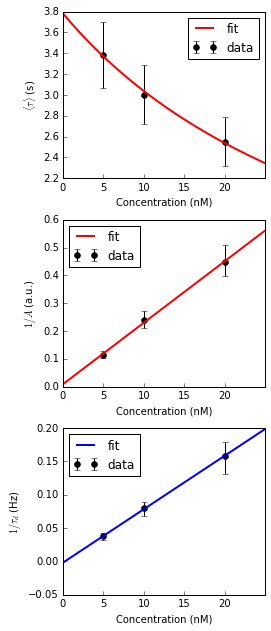

In [44]:
%matplotlib inline
#### Statistics of observables
X_stats=cseries._stats(X,CycleTime)

#### Concentration series fitting
X,X_stats,X_fit=cseries._fit(X.drop(outliers),X_stats.drop(outliers))

#### Save results
if save_results:
    X_stats.to_hdf(os.path.join(savedir,savename+'_stats.h5'),key='stats')
    X_fit.to_hdf(os.path.join(savedir,savename+'_fit.h5'),key='fit')

#### Plot and print results
cseries._plot(X_stats,X_fit)

print('lbFCS')
print('    koff = %.2e'%(X_fit.loc['lbfcs','popt0']))
print('    kon  = %.2e'%(X_fit.loc['lbfcs','popt1']))
print('    N  = %.2f'%(X.N.median()))
print('qPAINT')
print('    kon  = %.2e'%(X_fit.loc['qpaint','popt0']))

### Howto: Select subset of data and plot distributions
* Select variable via `field='variable'`
* Select subset fo data via `subset` (comment for disabling)
    * Select a certain measurement by e.g. `subset='20.0nM-1'`
    * Boolean selection via `subset=X.conc>=10`, e.g. all picks with imager concentration $\geq$ 10 nM
* Select histogram bins (comment for disabling)
    * `bins='fd'` adjusts bins automatically via [Freedman Diakonis rule](https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule)
    * Or custom bins via e.g. `bins=np.arange(0,5,0.1)`

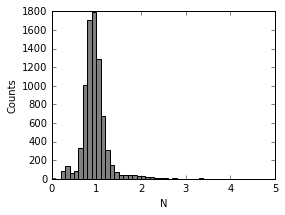

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

field='N'
subset='20.0nM-1' # Certain measurement
subset=X.conc>=10 # Boolean subset, e.g. imager concentration > 10nM

bins='fd'
bins=np.arange(0,5,0.1)

f=plt.figure(1,figsize=[4,3])
f.clear()

ax=f.add_subplot(111)
ax.hist(X.loc[subset,field].dropna(),bins=bins,edgecolor='k',color='gray');
ax.set_xlim(0,5);
ax.set_xlabel(field);
ax.set_ylabel('Counts');